In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1147, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1147 (delta 47), reused 40 (delta 36), pack-reused 1077 (from 1)
Receiving objects: 100% (1147/1147), 30.19 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (704/704), done.
Filtering content: 100% (33/33), 1.75 GiB | 152.41 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install pykalman
!pip install ta
!pip install scikit-optimize

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0

  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux

In [6]:
# bunch of the initialization code #

### RESULTS IMPORTS ###
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any, Sequence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoConfig
from torch.utils.data import DataLoader, TensorDataset

# Custom Imports
from models.statistical_models import kalman_filter_average, kalman_filter_regression
from models.transformer_model import TimeSeriesTransformerv1, get_cosine_schedule_with_warmup_and_min_lr
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###


### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt import plots as skplots
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple
import time
import random
from sklearn.metrics import mean_squared_error
from functools import partial


from utils.helpers import return_score
from utils.visualization import results_to_latex
from utils.optimization import bayesian_optimize_workflow
### HYPERPARAM OPTIMIZATION IMPORTS ###

# 1. Optimization

## Kalman Filter

In [ ]:
search_space_kalman = [ # 'name' is used directly as a kwarg
    Real(1e-5, 0.1, name='delta', prior='log-uniform'),
    Real(0.5, 4, name='obs_cov_reg', prior='log-uniform'),
    Real(0.001, 0.1, name='trans_cov_avg', prior='log-uniform'),
    Real(0.1, 10, name='obs_cov_avg', prior='log-uniform')
]
SEED = 3178749

# call func
res_kalman = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=3,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_kalman,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_kalman]
best_params = {k: res_kalman.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_kalman.fun
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")

In [ ]:
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_kalman, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_kalman)
ax.set_title("Bayesian Optimization Convergence plot Kalman Filter")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

## Transformer

In [53]:
search_space_transformer = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: architecture ##
  Categorical([256, 512, 1024], name='d_model'),  # must be powers of 2
  Categorical([2, 8, 16], name='nhead'),
  Integer(2, 6, name='num_layers'),
  Real(0.0, 0.3, name='dropout'),
  ## optimized hyperparams: architecture ##

  ## optimized hyperparams: learning algorithm ##
  Real(1e-6, 1e-4, prior='log-uniform', name='learning_rate'), # too high of a learning rate will cause exploding gradients, resulting in very high MSE or nans in outputs
  Real(1e-6, 1e-4, prior='log-uniform', name='min_learning_rate'),
  Real(0.0, 0.05, name='warmup_ratio'),
  Real(0.0, 0.3, name='weight_decay'),
  Categorical([64, 128], name='batch_size'),
  Real(0.85, 0.99, name='adam_beta1'),
  Real(0.9, 0.999, name='adam_beta2'),
  Real(1e-11, 1e-8, prior='log-uniform', name='adam_epsilon')
  ## optimized hyperparams: learning algorithm ##
]

SEED = 3178749

fixed_params = {'epochs': 10}
execute_transformer_workflow_fixed_params = partial(execute_transformer_workflow, **fixed_params)

# call func
res_transformer = bayesian_optimize_workflow(
    execute_workflow_fn=execute_transformer_workflow_fixed_params,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_transformer,
    n_calls=30,
    seed=SEED,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Current hyperparameters: {'d_model': 512, 'nhead': 2, 'num_layers': 6, 'dropout': 0.24532990507861047, 'learning_rate': 3.543313023647247e-05, 'min_learning_rate': 3.1114452922599073e-06, 'warmup_ratio': 0.04161462758883802, 'weight_decay': 0.14372393142085188, 'batch_size': 128, 'adam_beta1': 0.9873355316199921, 'adam_beta2': 0.91648264436139, 'adam_epsilon': 4.664012054704713e-10}
Epoch 010 | train MSE 0.116536 | val MSE 0.091099
Epoch 010 | train MSE 0.100529 | val MSE 0.059017
Epoch 010 | train MSE 0.114353 | val MSE 0.012783
Epoch 010 | train MSE 0.148236 | val MSE 0.280005
total_mse_list: [7.934625049682245, 6.640895915550856, 0.5313675556766491, 7.04900135341144]
mean mse: 5.5389724685802975
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 42.5355
Function value obtained: 5.5390
Current minimum: 5.5390
Iteration No: 2 started. Evaluating function at random point.
Current hyperparameters: {'d_model':

In [54]:
param_names_transformer = [dim.name for dim in search_space_transformer]
best_params_transformer = {k: res_transformer.x[i] for i, k in enumerate(param_names_transformer)}
best_mean_mse_transformer = res_transformer.fun
print(f"best_params: {best_params_transformer}")
print(f"best_mean_mse: {best_mean_mse_transformer}")

best_params: {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}
best_mean_mse: 0.5856978985989921


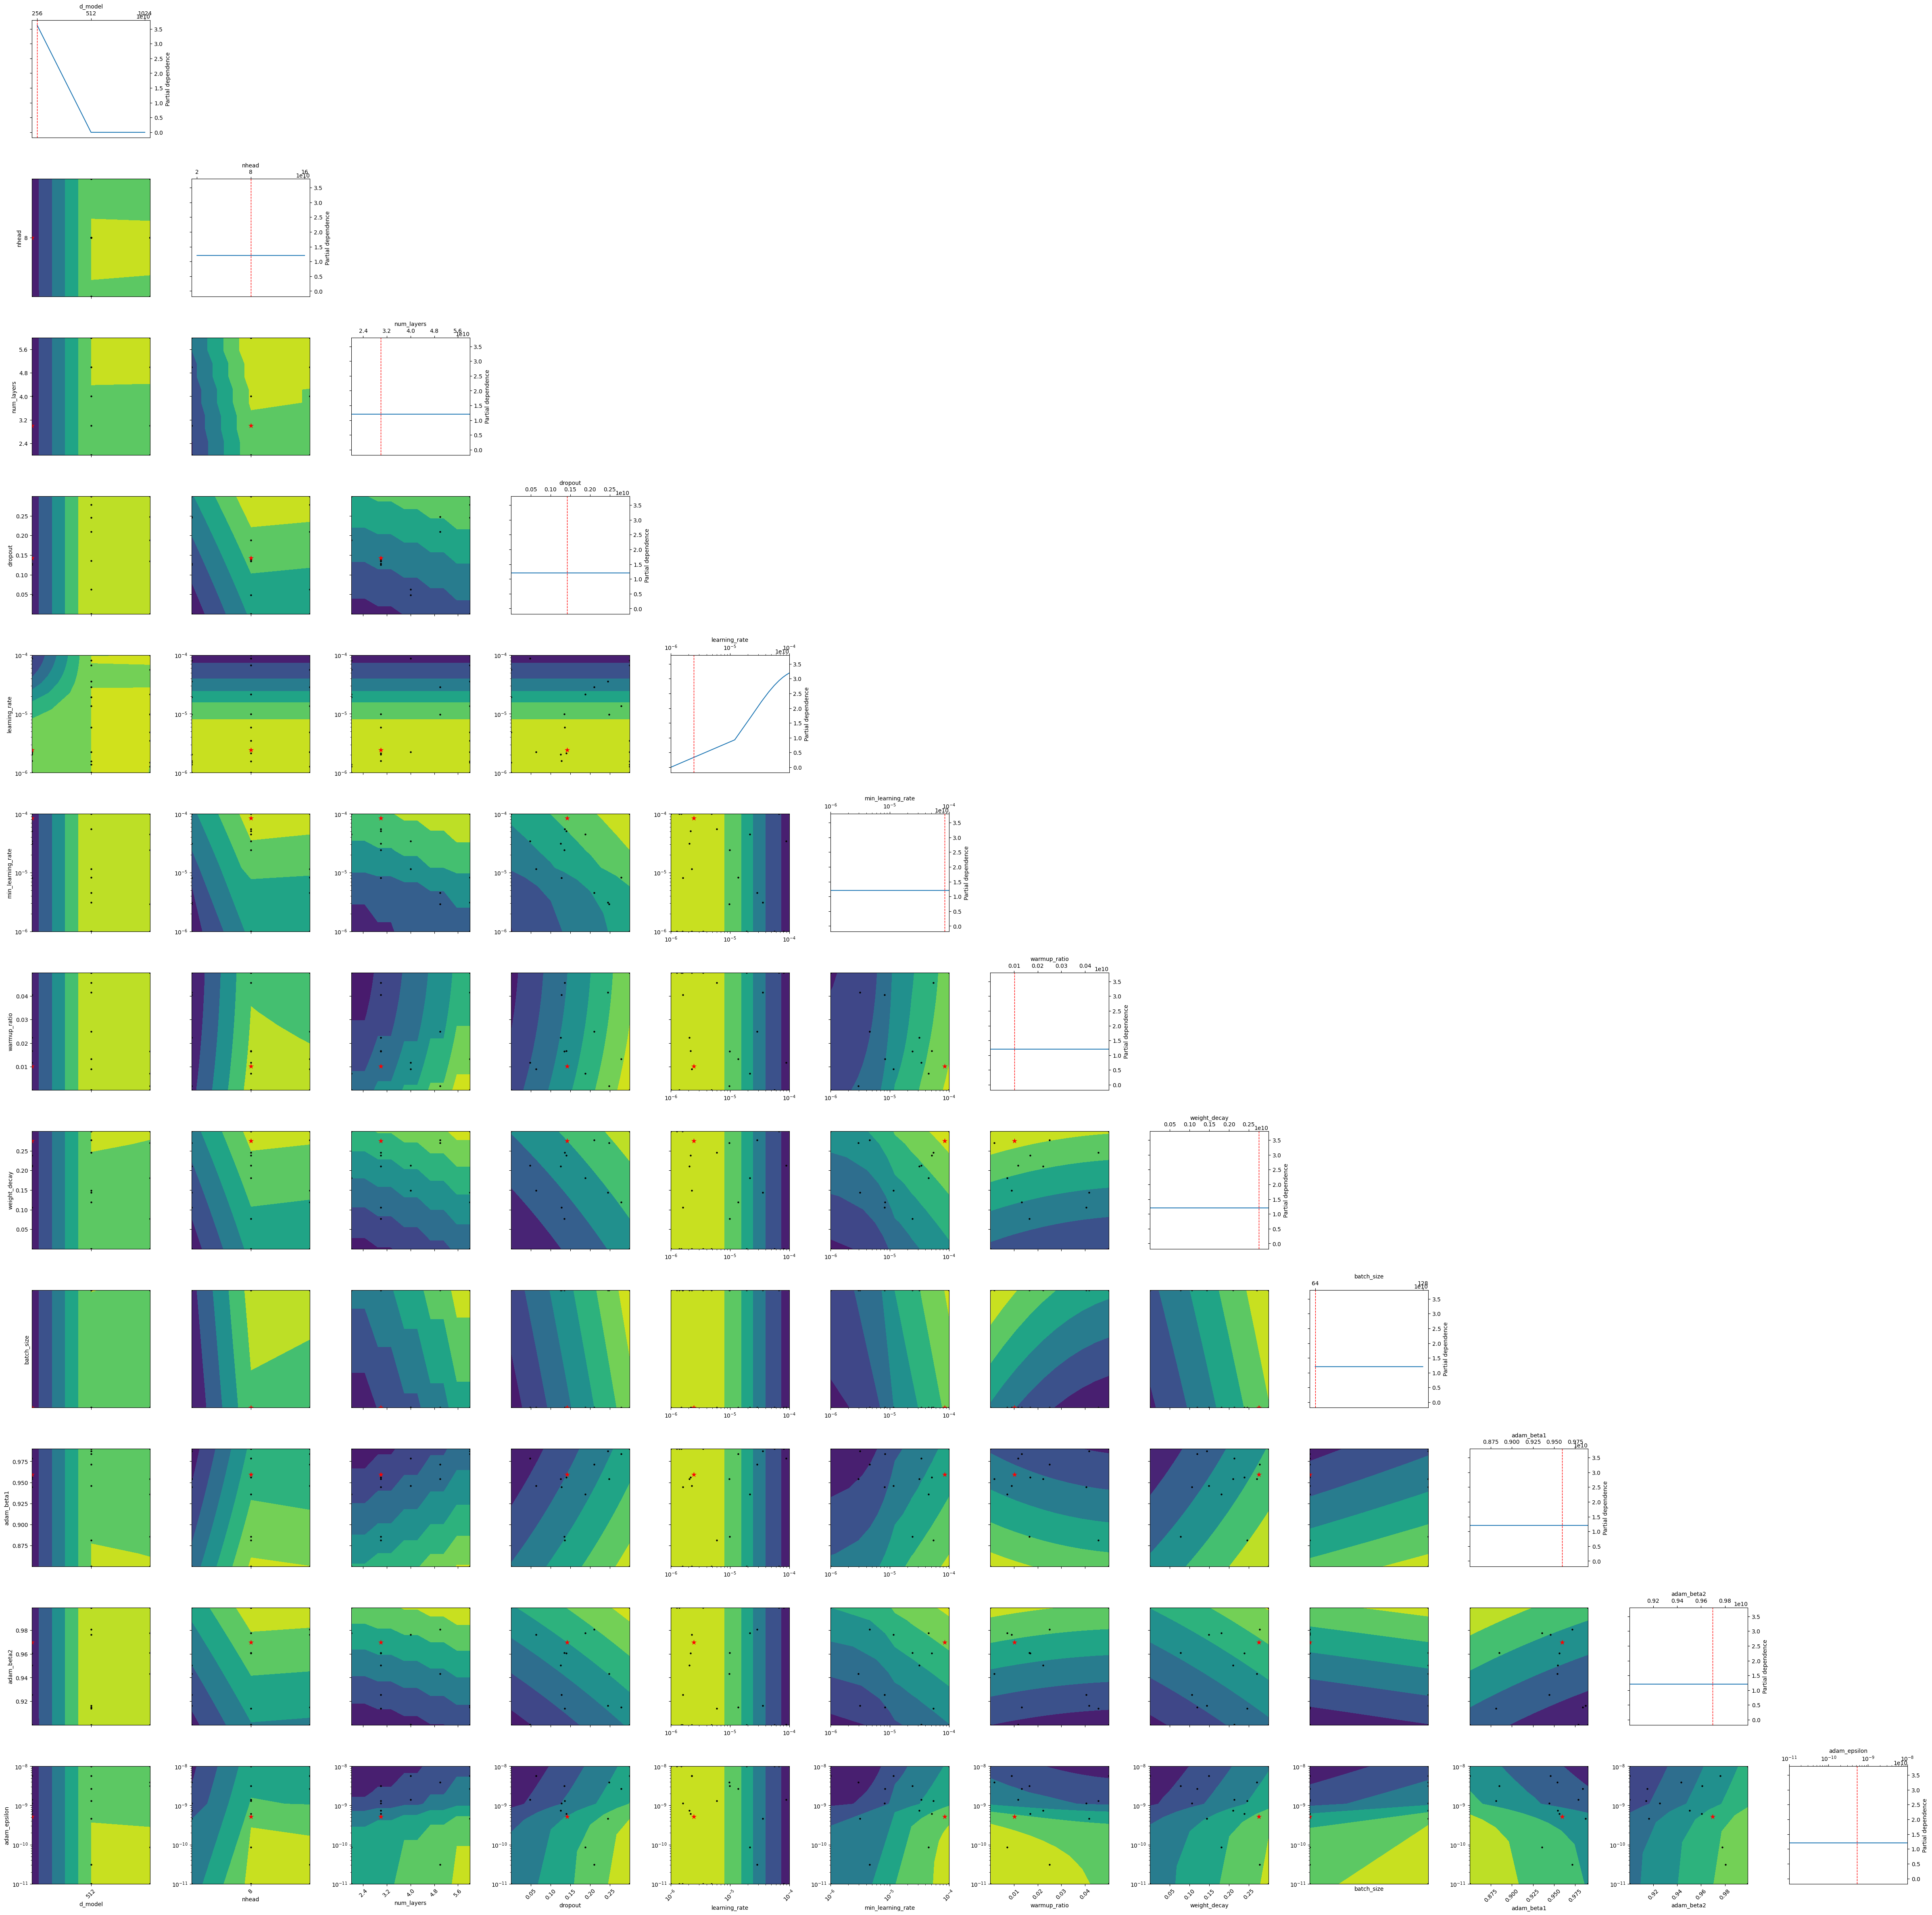

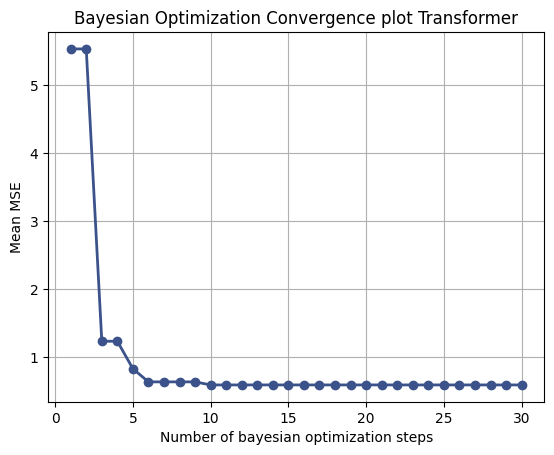

In [55]:
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_transformer, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_transformer)
ax.set_title("Bayesian Optimization Convergence plot Transformer")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

## Time-MoE

In [ ]:
search_space_timemoe = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: learning algorithm ##
  Real(1e-6, 1e-4, prior='log-uniform', name='learning_rate'), # too high of a learning rate will cause exploding gradients, resulting in very high MSE or nans in outputs
  Real(1e-6, 1e-4, prior='log-uniform', name='min_learning_rate'),
  Real(0.0, 0.05, name='warmup_ratio'),
  Real(0.0, 0.3, name='weight_decay'),
  Categorical([64, 128], name='batch_size'),
  Real(0.85, 0.99, name='adam_beta1'),
  Real(0.9, 0.999, name='adam_beta2'),
  Real(1e-11, 1e-8, prior='log-uniform', name='adam_epsilon')
  ## optimized hyperparams: learning algorithm ##
]
SEED = 3178749

# call func
res_timemoe = bayesian_optimize_workflow(
    execute_workflow_fn=execute_timemoe_workflow,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2021,
    search_space=search_space_timemoe,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_timemoe]
best_params = {k: res_timemoe.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_timemoe.fun

Iteration No: 1 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}
2025-06-16 17:21:46,362 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2766.69it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:21:51,067 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4894.17it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:21:56,231 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 84.82it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:01,303 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3315.66it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:06,917 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4629.47it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:12,649 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4905.62it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949, 0.04093752433417284, 0.10666511934953458]
mean mse: 0.14580852562932653
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 32.3722
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 2 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 3.426154615849745e-05, 'min_learning_rate': 9.160858309833609e-05, 'warmup_ratio': 0.008324567859287892, 'weight_decay': 0.16687596642391597, 'batch_size': 64, 'adam_beta1': 0.9089354148779092, 'adam_beta2': 0.9616380065480887, 'adam_epsilon': 3.006622954548625e-11}
2025-06-16 17:22:18,748 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5874.38it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:23,574 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5071.71it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:29,063 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4771.68it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:34,213 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4837.72it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:39,668 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2312.19it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:45,381 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4405.78it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907, 0.04093752142686426, 0.10666511934953458]
mean mse: 0.14580853937204938
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 32.4359
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 3 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 8.830965232159592e-05, 'min_learning_rate': 3.424859195383696e-05, 'warmup_ratio': 0.01168563921691556, 'weight_decay': 0.2127749148484082, 'batch_size': 64, 'adam_beta1': 0.9785553685576249, 'adam_beta2': 0.9002924364184774, 'adam_epsilon': 1.41830236888153e-09}
2025-06-16 17:22:51,174 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3927.25it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:22:56,229 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4519.72it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:01,244 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5165.40it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:06,558 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:12,299 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5159.05it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:18,303 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5090.17it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907, 0.04093752142686426, 0.10666511934953458]
mean mse: 0.14580853937204938
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 32.8640
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 4 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 2.061962256331083e-05, 'min_learning_rate': 3.801125176371274e-05, 'warmup_ratio': 0.036008737636124596, 'weight_decay': 0.20994270385992123, 'batch_size': 128, 'adam_beta1': 0.8960244194548778, 'adam_beta2': 0.9494211313960338, 'adam_epsilon': 6.034577184973604e-09}
2025-06-16 17:23:24,036 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5714.31it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:28,802 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4578.93it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:33,825 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2431.48it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:38,903 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:44,382 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4271.19it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:23:49,874 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4848.91it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949, 0.04093752433417284, 0.10666511934953458]
mean mse: 0.14580852562932653
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 32.5872
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 5 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 3.8532649225825855e-06, 'min_learning_rate': 5.43532088247193e-05, 'warmup_ratio': 0.04062324873823531, 'weight_decay': 0.04871635037633412, 'batch_size': 64, 'adam_beta1': 0.9029628740429356, 'adam_beta2': 0.9132358672824176, 'adam_epsilon': 2.2883200304747968e-10}
2025-06-16 17:23:56,623 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2100.30it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:01,524 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4165.15it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:06,974 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4310.69it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:12,260 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4733.98it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:17,913 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5197.40it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:23,600 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4510.00it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907, 0.04093752142686426, 0.10666511934953458]
mean mse: 0.14580853937204938
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 32.6634
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 6 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 5.928814032392102e-06, 'min_learning_rate': 5.469825836261845e-05, 'warmup_ratio': 0.04563064276122492, 'weight_decay': 0.24594992467363028, 'batch_size': 64, 'adam_beta1': 0.8811602429987699, 'adam_beta2': 0.9140999216428032, 'adam_epsilon': 1.3036928150420823e-09}
2025-06-16 17:24:29,461 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3008.83it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:34,320 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2238.16it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:39,449 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4911.36it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:44,596 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4865.78it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:50,083 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4665.52it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:24:56,121 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4946.11it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907, 0.04093752142686426, 0.10666511934953458]
mean mse: 0.14580853937204938
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 32.5779
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 7 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 5.8853415539448134e-05, 'min_learning_rate': 9.020482107494073e-06, 'warmup_ratio': 0.0036360942851451205, 'weight_decay': 0.18827524005553803, 'batch_size': 128, 'adam_beta1': 0.9658110794594795, 'adam_beta2': 0.9140201539785365, 'adam_epsilon': 6.426970542603885e-10}
2025-06-16 17:25:01,926 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2859.10it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:07,187 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2258.65it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:12,265 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5370.43it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:17,285 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4599.02it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:22,636 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4750.06it/s]


Step,Training Loss
1,0.010800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:28,158 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3313.04it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949, 0.04093752433417284, 0.10666511934953458]
mean mse: 0.14580852562932653
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 32.6054
Function value obtained: 0.1458
Current minimum: 0.1458
Iteration No: 8 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 8.629943239721477e-06, 'min_learning_rate': 1.6752338415288314e-05, 'warmup_ratio': 0.03919575929957089, 'weight_decay': 0.09347607399263154, 'batch_size': 128, 'adam_beta1': 0.8854170989931313, 'adam_beta2': 0.9680697149224714, 'adam_epsilon': 3.0133445050546737e-09}
2025-06-16 17:25:34,538 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3313.04it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:39,241 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2603.54it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:44,278 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2484.78it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:25:49,358 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4629.47it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# 2. Results

In [13]:
### Unchanged variables ###
verbose = True
return_datasets = True
### Unchanged variables ###

## Kalman Filter

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
    delta=1e-3,
    obs_cov_reg= 2.,
    trans_cov_avg= 0.01,
    obs_cov_avg= 1.
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
results_kalman_2022 = []
all_outputs_kalman_2022 = []
num_results = min(len(pairs_data_filtered), 8)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_kalman_2022.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_kalman_2022.append(output_model)

In [ ]:
  # test_s1_shortened=test_s1,
  # test_s2_shortened=test_s2,
  # forecast_test_shortened_series=forecast_test_series,
  # gt_test_shortened_series=gt_test_series
for i, output in enumerate(all_outputs_kalman_2022):
    # gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    # plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True)
    # plt.show()
    plt.title(f"MSE: {output['test_mse']}")
    plt.plot(output['pairs_timeseries']['Spread_Close'], label="Entire timeseries")
    # plt.plot(output['forecast_series'], label="forecast_series")
    plt.plot(output['forecast_series_normalized'], label="forecast_series_normalized")
    plt.plot(output['forecast_series_normalized_without_lookahead_bias'], label="forecast_series_normalized_without_lookahead_bias")
    plt.plot(output['forecast_series_starting_from_test_scaled_with_dev'], label="forecast_series_starting_from_test_scaled_with_dev")
    plt.plot(output['gt_test_shortened_series'], label="gt_test_shortened_series")
    plt.legend()
    plt.show()

In [ ]:
print(results_to_latex(results_kalman_2022))

## Transformer

In [57]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}


### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
results_transformer_2024 = []
all_outputs_transformer_2024 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, epochs=300, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_transformer_2024.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_transformer_2024.append(output_model)

Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Using device: cuda
Split sizes — train: 3774, dev: 251, test: 252
Epoch 010 | train MSE 0.633990 | val MSE 0.100174
Epoch 020 | train MSE 0.249710 | val MSE 0.068498
Epoch 030 | train MSE 0.167598 | val MSE 0.046933
Epoch 040 | train MSE 0.119153 | val MSE 0.030960
Epoch 050 | train MSE 0.084400 | val MSE 0.021660
Epoch 060 | train MSE 0.071022 | val MSE 0.017767
Epoch 070 | train MSE 0.056709 | val MSE 0.016519
Epoch 080 | train MSE 0.049345 | val MSE 0.015240
Epoch 090 | train MSE 0.043051 | val MSE 0.014044
Epoch 100 | train MSE 0.039044 | val MSE 0.012503
Epoch 110 | train MSE 0.033118 | val MSE 0.011385
Epoch 120 | train MSE 0.031216 | val MSE 0.009842
Epoch 130 | train MSE 0.027169 | val MSE 0.010442
Epoch 140 | train MSE 0.027518 | val MSE 0.009631
Epoch 150 | train MSE 0.025742 | val MSE 0.008928
Epoch 160 | train MSE 0.024524 | val MSE 0.010023
Epoch 170 | train MSE 0.022956 | val MSE 0.009635
Epoch 180 | train MSE 0.028256 | val MSE 0.009445
Epoch 190 | train MSE 0.026767 | v

In [59]:
print(results_to_latex(results_transformer_2022))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.15000 & 0.14245 & $0.11\% \pm 0.01\%$ & 0.10\% & 1.00 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.47036 & 0.29027 & $-72.77\% \pm 47.72\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.10872 & 0.15208 & $0.35\% \pm 0.02\%$ & 0.39\% & 1.00 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.08394 & 0.09651 & $0.09\% \pm 0.00\%$ & 0.05\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.07015 & 0.22685 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.09081 & 0.25826 & $-0.21\% \pm 0.03\%$ & -0.25\% & 1.00 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.53958 & 0.44944 & TLOE* & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.85777 & 17.19063 & $15.15\% \pm 0.46\%$ & 26.74\% & 0

In [31]:
val_targets_original_scale, val_preds_original_scale, val_preds_scaled, val_targets_scaled, dev_loader, model, trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std, devX_raw, devX_scaled, devY_raw, devY_scaled, testX_raw, testX_scaled, testY_raw, testY_scaled = output_model
dataloader = dev_loader
device = "cuda" if torch.cuda.is_available() else "cpu"
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch).cpu().numpy() # sometimes returns only nans, likely due to exploding gradients
        targets = y_batch.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets)
all_preds = np.concatenate(all_preds).reshape(-1, 1)
all_targets = np.concatenate(all_targets).reshape(-1, 1)
all_preds, all_targets

(array([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [ ]:
for i, output in enumerate(all_outputs_transformer_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_transformer_2022_{i}")

## Time-MoE

In [71]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
  ## optimized hyperparams: learning algorithm ##
  learning_rate=1e-4,
  min_learning_rate=5e-5,
  warmup_ratio=0.0,
  weight_decay=0.1,
  global_batch_size=64, # (just the batch size) other option would be micro_batch_size, which sets batch size per device
  adam_beta1=0.9,
  adam_beta2=0.95,
  adam_epsilon=1e-8,
  ## optimized hyperparams: learning algorithm ##
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###
### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
results_timemoe_2024 = []
all_outputs_timemoe_2024 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe_2024.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_timemoe_2024.append(output_model)


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:09:26,761 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4447.83it/s]


Step,Training Loss
1,0.032700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.11154355251742322
Test MSE: 0.11541403505599283
YOY Returns: 0.09%
YOY Std: +- 0.01%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:09:37,212 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1376.08it/s]


Step,Training Loss
1,0.020600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.25656439592477115
Test MSE: 0.1502973483768823
YOY Returns: -42.16%
YOY Std: +- 51.19%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:09:47,574 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1658.48it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09202838917172301
Test MSE: 0.07113812065778759
YOY Returns: -10.36%
YOY Std: +- 31.33%
GT Yoy: 0.39%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:09:58,206 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


Step,Training Loss
1,0.025800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06788223531333357
Test MSE: 0.11164555666516295
YOY Returns: 0.03%
YOY Std: +- 0.01%
GT Yoy: 0.05%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:10:08,924 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1422.28it/s]


Step,Training Loss
1,0.012600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.10350387800119906
Test MSE: 0.17038906968838682
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:10:19,585 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3261.51it/s]


Step,Training Loss
1,0.032400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.10719195593186111
Test MSE: 0.22577068332509187
YOY Returns: -0.21%
YOY Std: +- 0.05%
GT Yoy: -0.25%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:10:30,182 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5041.23it/s]


Step,Training Loss
1,0.020000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.20777181688563306
Test MSE: 0.14727476473753934
YOY Returns: -62.72%
YOY Std: +- 51.15%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:10:40,396 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3313.04it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.3538831002600399
Test MSE: 1.1938796524946749
YOY Returns: -45.88%
YOY Std: +- 59.05%
GT Yoy: 26.74%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:10:50,495 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3548.48it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.34660234609549756
Test MSE: 1.7697026009082468
YOY Returns: -8.70%
YOY Std: +- 31.89%
GT Yoy: 11.34%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 17:11:00,486 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4665.52it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.060351582481220536
Test MSE: 0.18427959911335476
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,PPH)
  


In [ ]:
for i, output in enumerate(all_outputs_timemoe_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_timemoe_2022_{i}")